# Read in the data

In [1]:
import pandas as pd
import numpy as np
import re

%matplotlib inline

data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]

data = {}

for f in data_files:
    d = pd.read_csv("schools/{0}".format(f))
    data[f.replace(".csv", "")] = d

# Read in the surveys

In [2]:
all_survey = pd.read_csv("schools/survey_all.txt", delimiter="\t", encoding='windows-1252')
d75_survey = pd.read_csv("schools/survey_d75.txt", delimiter="\t", encoding='windows-1252')
survey = pd.concat([all_survey, d75_survey], axis=0)

survey["DBN"] = survey["dbn"]

survey_fields = [
    "DBN", 
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_11", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",
]
survey = survey.loc[:,survey_fields]
data["survey"] = survey

# Add DBN columns

In [3]:
data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]

def pad_csd(num):
    string_representation = str(num)
    if len(string_representation) > 1:
        return string_representation
    else:
        return "0" + string_representation
    
data["class_size"]["padded_csd"] = data["class_size"]["CSD"].apply(pad_csd)
data["class_size"]["DBN"] = data["class_size"]["padded_csd"] + data["class_size"]["SCHOOL CODE"]

# Convert columns to numeric

In [4]:
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
for c in cols:
    data["sat_results"][c] = pd.to_numeric(data["sat_results"][c], errors="coerce")

data['sat_results']['sat_score'] = data['sat_results'][cols[0]] + data['sat_results'][cols[1]] + data['sat_results'][cols[2]]

def find_lat(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lat = coords[0].split(",")[0].replace("(", "")
    return lat

def find_lon(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lon = coords[0].split(",")[1].replace(")", "").strip()
    return lon

data["hs_directory"]["lat"] = data["hs_directory"]["Location 1"].apply(find_lat)
data["hs_directory"]["lon"] = data["hs_directory"]["Location 1"].apply(find_lon)

data["hs_directory"]["lat"] = pd.to_numeric(data["hs_directory"]["lat"], errors="coerce")
data["hs_directory"]["lon"] = pd.to_numeric(data["hs_directory"]["lon"], errors="coerce")

# Condense datasets

In [5]:
class_size = data["class_size"]
class_size = class_size[class_size["GRADE "] == "09-12"]
class_size = class_size[class_size["PROGRAM TYPE"] == "GEN ED"]

class_size = class_size.groupby("DBN").agg(np.mean)
class_size.reset_index(inplace=True)
data["class_size"] = class_size

data["demographics"] = data["demographics"][data["demographics"]["schoolyear"] == 20112012]

data["graduation"] = data["graduation"][data["graduation"]["Cohort"] == "2006"]
data["graduation"] = data["graduation"][data["graduation"]["Demographic"] == "Total Cohort"]

# Convert AP scores to numeric

In [6]:
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

for col in cols:
    data["ap_2010"][col] = pd.to_numeric(data["ap_2010"][col], errors="coerce")

# Combine the datasets

In [7]:
combined = data["sat_results"]

combined = combined.merge(data["ap_2010"], on="DBN", how="left")
combined = combined.merge(data["graduation"], on="DBN", how="left")

to_merge = ["class_size", "demographics", "survey", "hs_directory"]

for m in to_merge:
    combined = combined.merge(data[m], on="DBN", how="inner")

combined = combined.fillna(combined.mean())
combined = combined.fillna(0)

# Add a school district column for mapping

In [8]:
def get_first_two_chars(dbn):
    return dbn[0:2]

combined["school_dist"] = combined["DBN"].apply(get_first_two_chars)

# Find correlations

In [9]:
correlations = combined.corr()
correlations = correlations["sat_score"]
print(correlations)

SAT Critical Reading Avg. Score         0.986820
SAT Math Avg. Score                     0.972643
SAT Writing Avg. Score                  0.987771
sat_score                               1.000000
AP Test Takers                          0.523140
Total Exams Taken                       0.514333
Number of Exams with scores 3 4 or 5    0.463245
Total Cohort                            0.325144
CSD                                     0.042948
NUMBER OF STUDENTS / SEATS FILLED       0.394626
NUMBER OF SECTIONS                      0.362673
AVERAGE CLASS SIZE                      0.381014
SIZE OF SMALLEST CLASS                  0.249949
SIZE OF LARGEST CLASS                   0.314434
SCHOOLWIDE PUPIL-TEACHER RATIO               NaN
schoolyear                                   NaN
fl_percent                                   NaN
frl_percent                            -0.722225
total_enrollment                        0.367857
ell_num                                -0.153778
ell_percent         

# Plotting survey correlations

In [10]:
# Remove DBN since it's a unique identifier, not a useful numerical value for correlation.
survey_fields.remove("DBN")

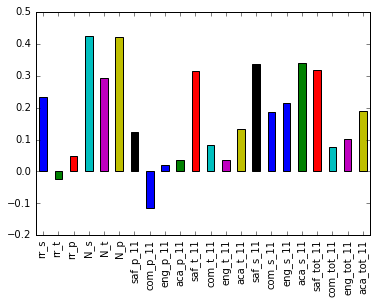

In [11]:
correlations.loc[survey_fields].plot(kind='bar')

# Investigating correlation between Safety & SAT Score

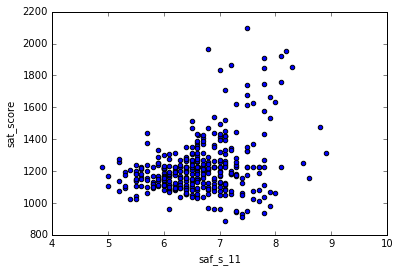

In [12]:
combined.plot(kind='scatter', x='saf_s_11', y='sat_score')

In [13]:
combined #['saf_tot_11']

,DBN,SCHOOL NAME,Num of SAT Test Takers,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score,sat_score,SchoolName,AP Test Takers,Total Exams Taken,...,priority05,priority06,priority07,priority08,priority09,priority10,Location 1,lat,lon,school_dist
0,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL STUDIES,29,355.000000,404.000000,363.000000,1122.000000,0,129.028846,197.038462,...,Then to New York City residents,0,0,0,0,0,"220 Henry Street\nNew York, NY 10002\n(40.7137...",40.713764,-73.985260,01
1,01M448,UNIVERSITY NEIGHBORHOOD HIGH SCHOOL,91,383.000000,423.000000,366.000000,1172.000000,UNIVERSITY NEIGHBORHOOD H.S.,39.000000,49.000000,...,0,0,0,0,0,0,"200 Monroe Street\nNew York, NY 10002\n(40.712...",40.712332,-73.984797,01
2,01M450,EAST SIDE COMMUNITY SCHOOL,70,377.000000,402.000000,370.000000,1149.000000,EAST SIDE COMMUNITY HS,19.000000,21.000000,...,0,0,0,0,0,0,"420 East 12 Street\nNew York, NY 10009\n(40.72...",40.729783,-73.983041,01
3,01M509,MARTA VALLE HIGH SCHOOL,44,390.000000,433.000000,384.000000,1207.000000,0,129.028846,197.038462,...,0,0,0,0,0,0,"145 Stanton Street\nNew York, NY 10002\n(40.72...",40.720569,-73.985673,01
4,01M539,"NEW EXPLORATIONS INTO SCIENCE, TECHNOLOGY AND ...",159,522.000000,574.000000,525.000000,1621.000000,"NEW EXPLORATIONS SCI,TECH,MATH",255.000000,377.000000,...,0,0,0,0,0,0,"111 Columbia Street\nNew York, NY 10002\n(40.7...",40.718725,-73.979426,01
5,01M696,BARD HIGH SCHOOL EARLY COLLEGE,130,624.000000,604.000000,628.000000,1856.000000,0,129.028846,197.038462,...,0,0,0,0,0,0,"525 East Houston Street\nNew York, NY 10002\n(...",40.718962,-73.976066,01
6,02M047,47 THE AMERICAN SIGN LANGUAGE AND ENGLISH SECO...,16,395.000000,400.000000,387.000000,1182.000000,0,129.028846,197.038462,...,0,0,0,0,0,0,"223 East 23 Street\nNew York, NY 10010\n(40.73...",40.738599,-73.982512,02
7,02M288,FOOD AND FINANCE HIGH SCHOOL,62,409.000000,393.000000,392.000000,1194.000000,0,129.028846,197.038462,...,0,0,0,0,0,0,"525 West 50Th Street\nNew York, NY 10019\n(40....",40.765027,-73.992517,02
8,02M294,ESSEX STREET ACADEMY,53,394.000000,384.000000,378.000000,1156.000000,0,129.028846,197.038462,...,0,0,0,0,0,0,"350 Grand Street\nNew York, NY 10002\n(40.7168...",40.716867,-73.989532,02
9,02M296,HIGH SCHOOL OF HOSPITALITY MANAGEMENT,58,374.000000,375.000000,362.000000,1111.000000,High School of Hospitality Management,129.028846,197.038462,...,0,0,0,0,0,0,"525 West 50Th Street\nNew York, NY 10019\n(40....",40.765027,-73.992517,02


In [14]:
from mpl_toolkits.basemap import Basemap

def create_map():
    m = Basemap(
        projection='merc', 
        llcrnrlat=40.496044, 
        urcrnrlat=40.915256, 
        llcrnrlon=-74.255735, 
        urcrnrlon=-73.700272,
        resolution='h'
    )

    m.drawmapboundary(fill_color='#85A6D9')
    m.drawcoastlines(color='#6D5F47', linewidth=.4)
    m.drawrivers(color='#6D5F47', linewidth=.4)
    
    return m;

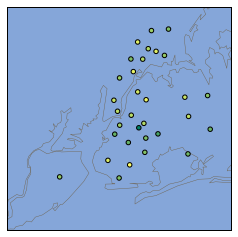

In [15]:
m = create_map()
districts = combined.groupby('school_dist').agg(np.mean)

m.scatter(districts['lon'].tolist(), districts['lat'].tolist(), latlon=True, s=20, zorder=2, c=districts['saf_tot_11'], cmap='summer')

In [16]:
def create_india_map():
    m = Basemap(
        projection='merc', 
        llcrnrlat=6.748885, 
        urcrnrlat=37.090303, 
        llcrnrlon=68.113996, 
        urcrnrlon=97.397638,
        resolution='i'
    )

    m.drawmapboundary(fill_color='#85A6D9')
    m.drawcoastlines(color='#6D5F47', linewidth=.4)
    m.drawcountries()
    # m.drawrivers(color='#6D5F47', linewidth=.4)
    
    return m;

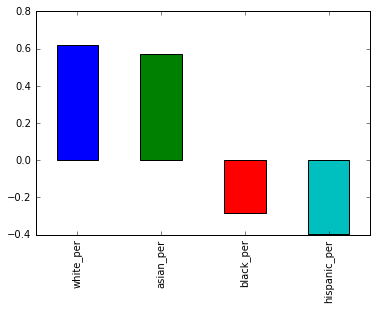

In [17]:
correlations.loc[['white_per', 'asian_per', 'black_per', 'hispanic_per']].plot(kind='bar')

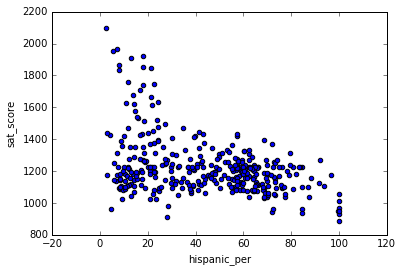

In [18]:
combined.plot(kind='scatter', x='hispanic_per', y='sat_score')

In [19]:
combined.loc[combined['hispanic_per'] > 95]

,DBN,SCHOOL NAME,Num of SAT Test Takers,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score,sat_score,SchoolName,AP Test Takers,Total Exams Taken,...,priority05,priority06,priority07,priority08,priority09,priority10,Location 1,lat,lon,school_dist
44,02M542,MANHATTAN BRIDGES HIGH SCHOOL,66,336.0,378.0,344.0,1058.0,Manhattan Bridges High School,67.000000,102.000000,...,0,0,0,0,0,0,"525 West 50Th Street\nNew York, NY 10019\n(40....",40.765027,-73.992517,02
82,06M348,WASHINGTON HEIGHTS EXPEDITIONARY LEARNING SCHOOL,70,380.0,395.0,399.0,1174.0,0,129.028846,197.038462,...,Then to New York City residents,0,0,0,0,0,"511 West 182Nd Street\nNew York, NY 10033\n(40...",40.848879,-73.930807,06
89,06M552,GREGORIO LUPERON HIGH SCHOOL FOR SCIENCE AND M...,56,339.0,349.0,326.0,1014.0,GREGORIO LUPERON HS SCI & MATH,88.000000,138.000000,...,0,0,0,0,0,0,"501 West 165Th\nNew York, NY 10032\n(40.838032...",40.838032,-73.938371,06
125,09X365,ACADEMY FOR LANGUAGE AND TECHNOLOGY,54,315.0,339.0,297.0,951.0,Academy for Language and Technology,20.000000,20.000000,...,0,0,0,0,0,0,"1700 Macombs Road\nBronx, NY 10453\n(40.849102...",40.849102,-73.916088,09
141,10X342,INTERNATIONAL SCHOOL FOR LIBERAL ARTS,49,300.0,333.0,301.0,934.0,International School for Liberal Arts,55.000000,73.000000,...,0,0,0,0,0,0,"2780 Reservoir Avenue\nBronx, NY 10468\n(40.87...",40.870377,-73.898163,10
176,12X388,PAN AMERICAN INTERNATIONAL HIGH SCHOOL AT MONROE,30,321.0,351.0,298.0,970.0,0,129.028846,197.038462,...,0,0,0,0,0,0,"1300 Boynton Avenue\nBronx, NY 10472\n(40.8313...",40.831366,-73.878823,12
253,19K583,MULTICULTURAL HIGH SCHOOL,29,279.0,322.0,286.0,887.0,Multicultural High School,44.000000,44.000000,...,0,0,0,0,0,0,"999 Jamaica Avenue\nBrooklyn, NY 11208\n(40.69...",40.691144,-73.868426,19
286,24Q296,PAN AMERICAN INTERNATIONAL HIGH SCHOOL,55,317.0,323.0,311.0,951.0,0,129.028846,197.038462,...,0,0,0,0,0,0,"45-10 94Th Street\nElmhurst, NY 11373\n(40.743...",40.743303,-73.870575,24


In [20]:
combined.loc[combined['hispanic_per'] < 10]

,DBN,SCHOOL NAME,Num of SAT Test Takers,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score,sat_score,SchoolName,AP Test Takers,Total Exams Taken,...,priority05,priority06,priority07,priority08,priority09,priority10,Location 1,lat,lon,school_dist
37,02M475,STUYVESANT HIGH SCHOOL,832,679.000000,735.000000,682.000000,2096.000000,STUYVESANT HS,1510.000000,2819.000000,...,0,0,0,0,0,0,"345 Chambers Street\nNew York, NY 10282\n(40.7...",40.717746,-74.014049,02
46,02M545,HIGH SCHOOL FOR DUAL LANGUAGE AND ASIAN STUDIES,78,412.000000,581.000000,431.000000,1424.000000,High School for Dual Language and Asian Studies,61.000000,96.000000,...,0,0,0,0,0,0,"350 Grand Street\nNew York, NY 10002\n(40.7168...",40.716867,-73.989532,02
151,10X445,BRONX HIGH SCHOOL OF SCIENCE,731,632.000000,688.000000,649.000000,1969.000000,BRONX HS OF SCIENCE,1190.000000,2435.000000,...,0,0,0,0,0,0,"75 West 205 Street\nBronx, NY 10468\n(40.87705...",40.877056,-73.889780,10
187,13K430,BROOKLYN TECHNICAL HIGH SCHOOL,1277,587.000000,659.000000,587.000000,1833.000000,BROOKLYN TECHNICAL HS,2117.000000,3692.000000,...,0,0,0,0,0,0,"29 Ft Greene Place\nBrooklyn, NY 11217\n(40.68...",40.688107,-73.976745,13
192,13K595,BEDFORD ACADEMY HIGH SCHOOL,89,438.000000,443.000000,431.000000,1312.000000,Bedford Academy High School,43.000000,57.000000,...,0,0,0,0,0,0,"1119 Bedford Avenue\nBrooklyn, NY 11216\n(40.6...",40.685381,-73.954268,13
194,13K670,BENJAMIN BANNEKER ACADEMY,185,471.000000,472.000000,448.000000,1391.000000,BENJAMIN BANNEKER ACADEMY,132.000000,149.000000,...,0,0,0,0,0,0,"71-77 Clinton Avenue\nBrooklyn, NY 11205\n(40....",40.695662,-73.969286,13
220,16K455,BOYS AND GIRLS HIGH SCHOOL,131,365.000000,370.000000,362.000000,1097.000000,BOYS AND GIRLS HS,22.000000,32.000000,...,0,0,0,0,0,0,"1700 Fulton Street\nBrooklyn, NY 11213\n(40.67...",40.679433,-73.932432,16
223,17K382,ACADEMY FOR COLLEGE PREPARATION AND CAREER EXP...,59,396.000000,374.000000,369.000000,1139.000000,Academy for College Preparation and Career Exp...,64.000000,82.000000,...,0,0,0,0,0,0,"911 Flatbush Avenue\nBrooklyn, NY 11226\n(40.6...",40.649440,-73.958431,17
226,17K528,THE HIGH SCHOOL FOR GLOBAL CITIZENSHIP,46,403.000000,385.000000,388.000000,1176.000000,"High School for Global Citizenship, The",20.000000,34.000000,...,0,0,0,0,0,0,"883 Classon Avenue\nBrooklyn, NY 11225\n(40.67...",40.670299,-73.961648,17
227,17K531,"SCHOOL FOR HUMAN RIGHTS, THE",35,348.000000,381.000000,359.000000,1088.000000,0,129.028846,197.038462,...,Then to New York City residents,0,0,0,0,0,"600 Kingston Avenue\nBrooklyn, NY 11203\n(40.6...",40.659517,-73.942546,17


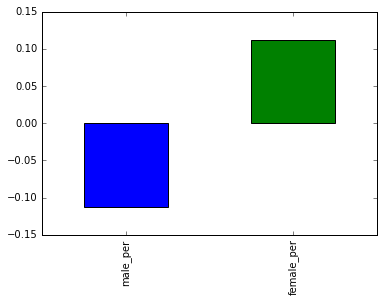

In [21]:
correlations.loc[['male_per', 'female_per']].plot(kind='bar')

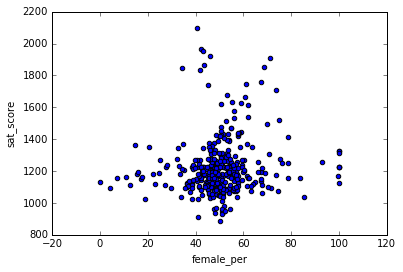

In [22]:
combined.plot(kind='scatter', x='female_per', y='sat_score')

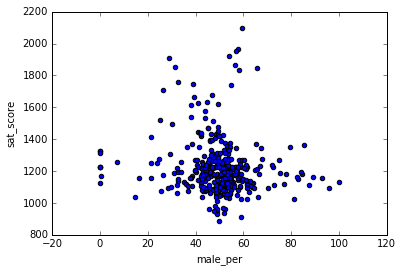

In [23]:
combined.plot(kind='scatter', x='male_per', y='sat_score')

In [24]:
combined['ap_per'] = combined['AP Test Takers '] / combined['total_enrollment']

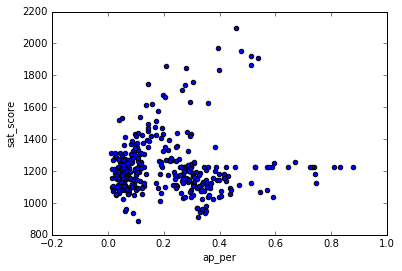

In [25]:
combined.plot(kind='scatter', x='ap_per', y='sat_score')